# Great Energy Predictor - Modeling (Electricity)
#### Hosted by: ASHRAE
##### Source: https://www.kaggle.com/c/ashrae-energy-prediction

## Section I: Dependencies and Data

### Dependencies

In [7]:
# Dependencies
import os
import gc
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import src.utils as udf

%matplotlib inline

In [6]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (15, 3)
mpl.rcParams['font.size'] = 12

### Data

In [8]:
# Data path
data_path = os.path.join('..', 'data', '03-feat-out')
data_path

'../data/03-feat-out'

In [9]:
# Electricity meter data
electricity = pd.read_pickle(os.path.join(data_path, 'electricity.pkl'))
electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11481619 entries, 0 to 18205341
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20  

In [10]:
# Chilled water meter data
chilledwater = pd.read_pickle(os.path.join(data_path, 'chilledwater.pkl'))
chilledwater.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3507966 entries, 70 to 18205292
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20  

In [11]:
# Steam meter data
steam = pd.read_pickle(os.path.join(data_path, 'steam.pkl'))
steam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2296049 entries, 762 to 18205336
Data columns (total 22 columns):
 #   Column              Dtype         
---  ------              -----         
 0   site_id             uint8         
 1   building_id         uint16        
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   air_temperature     float32       
 5   dew_temperature     float32       
 6   rel_humidity        float32       
 7   sea_level_pressure  float32       
 8   wind_speed          float32       
 9   wind_direction_x    float32       
 10  wind_direction_y    float32       
 11  primary_use         object        
 12  square_feet         uint32        
 13  year_built          uint16        
 14  missing_year        uint8         
 15  country             object        
 16  dayofyear           uint16        
 17  month               uint8         
 18  hour                uint8         
 19  dayofweek           uint8         
 20 

In [12]:
# Hot water meter data
hotwater = pd.read_pickle(os.path.join(data_path, 'hotwater.pkl'))
hotwater.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919708 entries, 10 to 18205124
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             919708 non-null  uint8         
 1   building_id         919708 non-null  uint16        
 2   timestamp           919708 non-null  datetime64[ns]
 3   meter_reading       919708 non-null  float32       
 4   air_temperature     919708 non-null  float32       
 5   dew_temperature     919708 non-null  float32       
 6   rel_humidity        919708 non-null  float32       
 7   sea_level_pressure  919708 non-null  float32       
 8   wind_speed          919708 non-null  float32       
 9   wind_direction_x    919708 non-null  float32       
 10  wind_direction_y    919708 non-null  float32       
 11  primary_use         919708 non-null  object        
 12  square_feet         919708 non-null  uint32        
 13  year_built          919708

In [14]:
feats = pd.read_pickle(os.path.join(data_path, 'feats.pkl'))
feats

,target_corr,lasso_coef,lasso_coef_recursive,tree_importance,tree_importance_recursive
0,square_feet,primary_use,primary_use,square_feet,site_id
1,country,square_feet,square_feet,year_built,air_temperature
2,,country,missing_year,country,primary_use
3,,is_weekend,country,,square_feet
4,,,dayofyear,,year_built
5,,,hour,,country
6,,,is_weekend,,dayofyear
7,,,is_holiday,,hour


In [16]:
# Clean vars
del data_path
gc.collect()

42

## Section II: Featurization - Electricity

Once again, we will be working primarily with the electricity meter data as it contains the most readings and the process used here will be repeated for the other 3 meters.

### Drop unused features

We will be dropping the features we found to be unnecessary in the featurization notebook - `site_id`, `building_id`, `dew_temperature`, `timestamp`, `month`, `dayofweek`. `Site_id` was added here because we have the `country` feature which is a good proxy for it.

In [10]:
# Drop features
to_drop = ['site_id', 'building_id', 'dew_temperature', 'timestamp', 'month', 'dayofweek']
electricity.drop(to_drop, axis=1, inplace=True)
electricity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11481619 entries, 0 to 18205341
Data columns (total 16 columns):
 #   Column              Dtype  
---  ------              -----  
 0   meter_reading       float32
 1   air_temperature     float32
 2   rel_humidity        float32
 3   sea_level_pressure  float32
 4   wind_direction_x    float32
 5   wind_direction_y    float32
 6   wind_speed          float32
 7   primary_use         object 
 8   square_feet         uint32 
 9   year_built          uint8  
 10  missing_year        uint8  
 11  country             object 
 12  dayofyear           uint16 
 13  hour                uint8  
 14  is_weekend          uint8  
 15  is_holiday          uint8  
dtypes: float32(7), object(2), uint16(1), uint32(1), uint8(5)
memory usage: 689.8+ MB


### Train/test split

The same 60-20-20 data split will be done here. Variables will be suffixed with "e" to indicate that it is `electricity` meter data.

In [11]:
# Split features and target
Xe = electricity.drop('meter_reading', axis=1).copy()
ye = electricity['meter_reading'].copy()
Xe.shape, ye.shape

((11481619, 15), (11481619,))

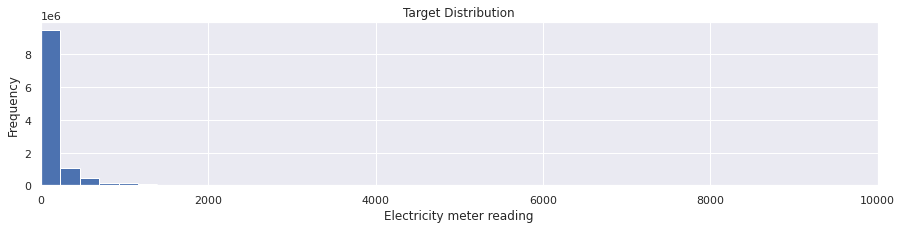

In [12]:
# Check the target distribution
ye.plot(kind='hist', bins=50, title='Target Distribution', xlim=(0, 1e4))
plt.xlabel('Electricity meter reading')
plt.show()

The raw meter readings are highly right-skewed. We may be able to get more accurate predictions if we transform the target variable into a normal distribution to increase its linearity with the features. To do this, we will do a log transformation on the target variable and train our models using the log-transformed target. Of course, when making predictions, the output will be log-transformed values, so the predictions will have to be inverse-transformed to yield the true output.

Note: the target variable contains meter readings of 0, so 1 will be added to all readings before taking the log (because log(0) is undefined) like this: `y_log_transformed = log(y + 1)`

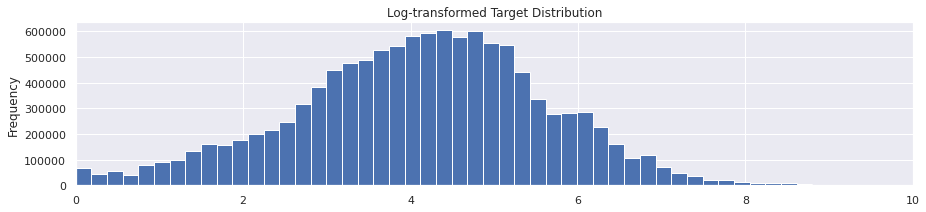

In [13]:
# Log transform the target variable
ye = np.log1p(ye)
ye.plot(kind='hist', bins=50, title='Log-transformed Target Distribution', xlim=(0, 10))
plt.show()

In [14]:
# Train/val/test split (60/20/20)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe, ye, test_size=0.4, random_state=0)
Xe_val, Xe_test, ye_val, ye_test = train_test_split(Xe_test, ye_test, test_size=0.5, random_state=0)

print('Train set:', Xe_train.shape, ye_train.shape)
print('Validation set:', Xe_val.shape, ye_val.shape)
print('Test set:', Xe_test.shape, ye_test.shape)
Xe_train.head(3)

Train set: (6888971, 15) (6888971,)
Validation set: (2296324, 15) (2296324,)
Test set: (2296324, 15) (2296324,)


,air_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,hour,is_weekend,is_holiday
11668719,26.1,82.086754,1015.400024,0.866025,0.500000,3.1,Office,26953,213,0,US,240,1,1,0
15417488,18.9,78.094246,1020.099976,0.766044,-0.642788,1.5,Education,66203,223,0,US,312,18,0,0
4404673,4.4,50.354458,1029.000000,-0.766044,-0.642788,4.6,Public services,400000,179,0,US,97,8,0,0


In [15]:
del Xe, ye
gc.collect()

12587

### Categorical feature encoding

Next, we will perform the 2 types of categorical encoding as in the featurization notebook:
1. Rare label categorical encoding - categorical labels that occur less than 5% in the data will be encoded as "Rare"
    - This will be done for `primary_use`
2. Mean target categorical encoding - categorical labels will be numerically encoded with the mean value of the target label for that particular label
    - This will be done for `primary_use` and `country`
    - Note: countries "UK" and "IE" were grouped into the label "EU"
    
The difference here is that the target label has been log-transformed, so the encoded values here will differ from the featurization notebook

In [16]:
# Group all rare primary_use categories
Xe_train, Xe_val, Xe_test, rare_dict = udf.rare_encoder(['primary_use'], Xe_train, Xe_test, val=Xe_val)
rare_dict

{'primary_use': Index(['Education', 'Office', 'Entertainment/public assembly',
        'Public services', 'Lodging/residential'],
       dtype='object')}

In [17]:
# Value counts for `primary_use`
print('##### Train set #####')
print(Xe_train.primary_use.value_counts())
print('\n##### Validation set #####')
print(Xe_val.primary_use.value_counts())
print('\n##### Test set #####')
print(Xe_test.primary_use.value_counts())

##### Train set #####
Education                        2635696
Office                           1310265
Entertainment/public assembly     871248
Public services                   788379
Lodging/residential               678847
Rare                              604536
Name: primary_use, dtype: int64

##### Validation set #####
Education                        877922
Office                           435865
Entertainment/public assembly    291572
Public services                  262875
Lodging/residential              226541
Rare                             201549
Name: primary_use, dtype: int64

##### Test set #####
Education                        879687
Office                           435391
Entertainment/public assembly    290427
Public services                  262464
Lodging/residential              226333
Rare                             202022
Name: primary_use, dtype: int64


In [18]:
# Encode categorical features using the target mean of each category
Xe_train, Xe_val, Xe_test, mean_dict = udf.mean_encoder(['primary_use', 'country'], 
                                                        Xe_train, ye_train, Xe_test, X_val=Xe_val)
mean_dict

{'primary_use': {'Education': 4.468423366546631,
  'Entertainment/public assembly': 3.523334264755249,
  'Lodging/residential': 3.9764797687530518,
  'Office': 4.195037364959717,
  'Public services': 3.760781764984131,
  'Rare': 3.770461320877075},
 'country': {'CA': 6.6370038986206055,
  'EU': 3.4172074794769287,
  'US': 4.179385185241699}}

In [19]:
# Encoded value counts in train set
print('##### Train set: primary_use #####')
print(Xe_train.primary_use.value_counts())
print('\n##### Train set: country #####')
print(Xe_train.country.value_counts())

##### Train set: primary_use #####
4.468423    2635696
4.195037    1310265
3.523334     871248
3.760782     788379
3.976480     678847
3.770461     604536
Name: primary_use, dtype: int64

##### Train set: country #####
4.179385    5885587
3.417207     922469
6.637004      80915
Name: country, dtype: int64


### Feature scaling

In [20]:
# Scale features using their mean and standard deviation
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled = udf.scale_feats(Xe_train, Xe_test, val=Xe_val)
Xe_train_scaled.head()

,air_temperature,rel_humidity,sea_level_pressure,wind_direction_x,wind_direction_y,wind_speed,primary_use,square_feet,year_built,missing_year,country,dayofyear,hour,is_weekend,is_holiday
0,0.977865,0.741393,-0.120466,1.352629,0.853826,-0.197988,0.256614,-0.589092,1.827039,-1.108092,0.193303,0.495444,-1.517191,1.577058,-0.180158
1,0.291863,0.562860,0.513359,1.204086,-0.880341,-0.886943,1.046239,-0.238802,2.298373,-1.108092,0.193303,1.180861,0.938746,-0.634092,-0.180158
2,-1.089669,-0.677575,1.713597,-1.072159,-0.880341,0.447907,-0.997653,2.740196,0.224504,-1.108092,0.193303,-0.865871,-0.505923,-0.634092,-0.180158
3,-1.299280,0.175473,1.201131,0.065963,0.095082,-1.532838,-1.683476,4.201882,-0.152563,0.902452,0.193303,-1.522729,-1.661658,-0.634092,-0.180158
4,-0.737140,-0.663548,1.956347,-0.192028,1.589516,0.921563,-0.374649,0.087578,-0.482496,-1.108092,-1.819603,1.380774,-0.072522,-0.634092,-0.180158


In [21]:
del Xe_train, Xe_val, Xe_test
gc.collect()

88

### Feature sets

Building on the featurization notebook, we will be creating several feature sets for model training to try see if we can get better predictions:
1. All features (15) - full feature set
2. Custom features (10) - drop the 5 features that were selected 0 times in the featurization notebook
    - `rel_humidity`, `sea_level_pressure`, `wind_direction_x`, `wind_direction_y`, `wind_speed`
3. Lasso RFE features (8) - features selected from the lasso RFE method
4. Tree RFE features (7) - features selected from the decision tree RFE method, except for `site_id`, which was just dropped

In [22]:
# Selected features from featurization notebook
feats

,target_corr,lasso_coef,lasso_coef_recursive,tree_importance,tree_importance_recursive
0,square_feet,primary_use,primary_use,square_feet,site_id
1,country,square_feet,square_feet,year_built,air_temperature
2,,country,missing_year,country,primary_use
3,,is_weekend,country,,square_feet
4,,,dayofyear,,year_built
5,,,hour,,country
6,,,is_weekend,,dayofyear
7,,,is_holiday,,hour


In [23]:
# Full feature set
all_feats = Xe_train_scaled.columns.tolist()
print(len(all_feats))
all_feats

15


['air_temperature',
 'rel_humidity',
 'sea_level_pressure',
 'wind_direction_x',
 'wind_direction_y',
 'wind_speed',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [24]:
# Custom feature set
custom_drop = ['rel_humidity', 'sea_level_pressure', 'wind_direction_x', 'wind_direction_y', 'wind_speed']
custom_feats = Xe_train_scaled.drop(custom_drop, axis=1).columns.tolist()

print(len(custom_feats))
custom_feats

10


['air_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [25]:
# Lasso RFE feature set
lasso_feats = feats['lasso_coef_recursive'].tolist()
print(len(lasso_feats))
lasso_feats

8


['primary_use',
 'square_feet',
 'missing_year',
 'country',
 'dayofyear',
 'hour',
 'is_weekend',
 'is_holiday']

In [26]:
# Decision tree RFE feature set
tree_feats = feats['tree_importance_recursive'].tolist()[1:]
print(len(tree_feats))
tree_feats

7


['air_temperature',
 'primary_use',
 'square_feet',
 'year_built',
 'country',
 'dayofyear',
 'hour']

In [27]:
del feats, custom_drop
gc.collect()

132

## Section III: Modeling - Electricity

With the 4 feature sets we just created, we will be training 3 different models - a linear model and 2 tree-based models:
1. `Lasso regression` (linear regression with L1 regularization) - this will be the baseline model for prediction performance
    - As we did use lasso regression to create one of the feature sets, that feature set is optimized for lasso regression, so this model may do quite well
2. LightGBM - a parallelizable gradient boosting machines (GBM) implementation that grows trees leaf-wise, which can reduce loss more than the commonly used depth-wise implementation *
    - Another one of the feature sets was created with decision tree, so that's why we are using tree-based models
3. XGBoost - another parallelizable GBM implementation that has a reputation of winning Kaggle competitions involving structured data
    - Although not as fast as LightGBM, I suspect this algorithm will produce the best predictions
    
For each of the 3 models above, we will be tuning the model hyperparameters and training it on each of the 4 feature sets to select the model with the highest scores. The metric we are using to evaluate model performance is the `root mean squared error`. This is the most commonly used metric for evaluating regression models, and for good reason: it is easy to compute and understand, much like the `mean absolute error`, but has the added benefit of penalizing larger errors more so that the optimization process can be more robust to outliers.

##### \* Note: Read more about LightGBM and XGBoost [here](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/). Pranjal provides a great comparison between the 2 algorithms.

### Lasso regression

Again, this will be the baseline model for performance. This will give us an idea of the performance we can expect with the data. With only 1 hyperparamer to tune, a simple for loop would do the trick. But we are going to take advantage of Scikit-learn's grid search for the detailed results it provides. The only thing we are tuning here is the `alpha` parameter, which controls the degree of L1 regularization in the model.

In [28]:
# Lasso regression with full feature set (15)
params = {'alpha': [10 ** e for e in range(-4, 2)]}
lasso15 = GridSearchCV(Lasso(random_state=0), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso15.fit(Xe_train_scaled, ye_train)
pd.DataFrame(lasso15.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  24 | elapsed:   35.1s remaining:   17.6s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   39.3s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.116370,-1.116607,-1.115951,-1.117037,-1.116491,0.000393,1
0.0010,-1.116380,-1.116616,-1.115960,-1.117044,-1.116500,0.000392,2
0.0100,-1.117120,-1.117382,-1.116698,-1.117792,-1.117248,0.000398,3
0.1000,-1.139569,-1.139799,-1.139120,-1.140224,-1.139678,0.000399,4
1.0000,-1.485414,-1.485675,-1.485209,-1.484830,-1.485282,0.000309,5
10.0000,-1.485414,-1.485675,-1.485209,-1.484830,-1.485282,0.000309,5


In [29]:
# Lasso regression with custom feature set (10)
params = {'alpha': [10 ** e for e in range(-4, 0)]}
lasso10 = GridSearchCV(Lasso(random_state=0), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso10.fit(Xe_train_scaled[custom_feats], ye_train)
pd.DataFrame(lasso10.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   15.1s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.119237,-1.119506,-1.118950,-1.119851,-1.119386,0.000333,1
0.0010,-1.119239,-1.119511,-1.118952,-1.119860,-1.119390,0.000335,2
0.0100,-1.119598,-1.119892,-1.119296,-1.120267,-1.119763,0.000359,3
0.1000,-1.139775,-1.139996,-1.139284,-1.140418,-1.139868,0.000409,4


In [30]:
# Lasso regression with lasso RFE feature set (8)
lasso8 = GridSearchCV(Lasso(random_state=0), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso8.fit(Xe_train_scaled[lasso_feats], ye_train)
pd.DataFrame(lasso8.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   12.3s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.128990,-1.129433,-1.128609,-1.129648,-1.129170,0.000401,1
0.0010,-1.128992,-1.129437,-1.128610,-1.129655,-1.129174,0.000404,2
0.0100,-1.129291,-1.129730,-1.128896,-1.129977,-1.129473,0.000414,3
0.1000,-1.144999,-1.145229,-1.144494,-1.145633,-1.145089,0.000412,4


In [31]:
# Lasso regression with decision tree RFE feature set (7)
lasso7 = GridSearchCV(Lasso(random_state=0), params, cv=4, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=-1)
lasso7.fit(Xe_train_scaled[tree_feats], ye_train)
pd.DataFrame(lasso7.cv_results_).set_index('param_alpha').iloc[:, 5:]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   11.2s finished


,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
param_alpha,,,,,,,
0.0001,-1.122640,-1.122912,-1.122351,-1.123326,-1.122807,0.000359,1
0.0010,-1.122641,-1.122915,-1.122353,-1.123333,-1.122810,0.000361,2
0.0100,-1.122875,-1.123168,-1.122577,-1.123608,-1.123057,0.000381,3
0.1000,-1.139775,-1.139996,-1.139284,-1.140418,-1.139868,0.000409,4


Out of the 4 feature sets, the full feature set produced the lowest error with an `alpha` value of `0.0001`. We can see that the error decreases as `alpha` decreases, but going from an `alpha` value of `0.001` to `0.0001` did not decrease the error by much, so it's unnecessary to go any smaller for `alpha`.

Even though there is little difference in error between the 4 feature sets, it's clear that using less features increases the error. But interestingly, the decision tree set (with 7 features) did slightly better than the lasso set (with 8 features). This suggests 2 things:
1. The 3 features present in both the custom set and lasso set, but absent from the tree set - `missing_year`, `is_weekend`, and `is_holiday` - are not providing much information to the model. This is because of the minimal difference in error with or without these features.
2. Either (or both) the features present in the tree set, but absent from the lasso set - `air_temperature` and `year_built` - are important features because the model did worse without them.

The top 2 choices here are:
1. Full set (15 features) - This would be the better option if the goal is to minimize prediction error
2. Decision tree set (7 features) - This would be the better option if the goal was to keep the model simple (minimize complexity) for better explainability without losing too much prediction performance

Since the goal here is to minimize the prediction error, we will be going with the full feature set. But first, let's check if the difference in prediction error between these two sets is similar when makinng predictions on the validation set.

In [32]:
# Lasso regression with tree set (7)
lasso7 = Lasso(alpha=1e-4, random_state=0).fit(Xe_train_scaled[tree_feats], ye_train)

# RMSE for predictions on train and validation sets
print('Decision Tree Feature Set')
print('-------------------------')
print('Training RMSE:', np.sqrt(mean_squared_error(ye_train, lasso7.predict(Xe_train_scaled[tree_feats]))))
print('Validation RMSE:', np.sqrt(mean_squared_error(ye_val, lasso7.predict(Xe_val_scaled[tree_feats]))))
print('-------------------------')

# Feature coefficients
pd.DataFrame(zip(tree_feats, lasso7.coef_), columns=['feat', 'coef']).sort_values('coef', ascending=False)

Decision Tree Feature Set
-------------------------
Training RMSE: 1.1228058261290472
Validation RMSE: 1.1240332865490208
-------------------------


,feat,coef
2,square_feet,0.816805
1,primary_use,0.289410
4,country,0.200245
3,year_built,0.149502
6,hour,0.057963
0,air_temperature,0.002877
5,dayofyear,-0.010735


In [33]:
# Lasso regression with full feature set (15)
lasso = Lasso(alpha=1e-4, random_state=0).fit(Xe_train_scaled, ye_train)

# RMSE for predictions on train and validation sets
print('Full Feature Set')
print('----------------')
print('Training RMSE:', np.sqrt(mean_squared_error(ye_train, lasso.predict(Xe_train_scaled))))
print('Validation RMSE:', np.sqrt(mean_squared_error(ye_val, lasso.predict(Xe_val_scaled))))
print('----------------')

# Feature coefficients
coefs = pd.DataFrame(zip(Xe_train_scaled.columns, lasso.coef_), columns=['feat', 'coef'])\
          .sort_values('coef', ascending=False)
coefs

Full Feature Set
----------------
Training RMSE: 1.1164884259890666
Validation RMSE: 1.1178666417409446
----------------


,feat,coef
7,square_feet,0.818479
6,primary_use,0.293400
10,country,0.179818
8,year_built,0.146047
12,hour,0.044884
9,missing_year,0.039700
11,dayofyear,0.011316
4,wind_direction_y,-0.005384
5,wind_speed,-0.019623
3,wind_direction_x,-0.021407


In [34]:
del lasso8, lasso10, lasso15, params, coefs
gc.collect()

994

The prediction error of the validation set confirms that training the model on the full feature set does a little better than using a reduced set, with the following root mean squared error (RMSE) scores:
- Full feature set: 1.1165 (train) and 1.1179 (validation)
- Decision tree RFE feature set: 1.1228 (train) and 1.1240 (validation)

### LightGBM

Now that we have a baseline model, let's see if we can do better with a gradient boosting model. With LightGBM, there are quite a bit of hyperparameters to tune. And with the cross-validation folds and number of options for each parameter, the number of trials can get exponentially high, so a parameter grid search is not feasible here.

Instead, we will use `Optuna` to optimize LightGBM's parameters. `Optuna` takes a Bayesian approach to hyperparameter tuning, learning from previous trials to optimize each parameter. This is much more efficient than a grid search, which does a brute force search through every parameter combination.

To use `Optuna`, we must define the objective function for the parameter optimization process. This objective function will be used on every trial to evaluate the model's prediction performance using that trial's parameters. On every trial of the `Optuna` study, the function will do the following:
1. Save the study object - to save progress in case it is interrupted
2. Define the parameters to tune and distribution of values to search for each parameter - `Optuna` uses a distribution of values, instead of a list of explicit values
    - This allows us to get more fine-grained with the parameter values
3. Create a LightGBM `Dataset` object for the data - the LightGBM model has its own data object so we must convert the data to said object in order to train the model
4. Train model - using both the training and validation sets for validation
5. Evaluate model on the validation set - predictions are made on the validation set and evaluated using the root mean squared error (RMSE)
    - Negative predictions are replaced with 0 because there can't be negative energy consumption
5. Return evaluation metric to minimize (model loss) - in this case, we are trying to minimize the RMSE

In [35]:
# Path for Optuna study
lgb_path = '../models/electricity/lgb/'
udf.mkdir(lgb_path)


def objective_lgb(trial):
    
    """ Objective function for Optuna study to optimize model hyperparameters """
    
    # Save study
    print(dt.datetime.now(), ' | Finished trials:', len(study_lgb.trials))
    joblib.dump(study_lgb, lgb_path + 'study_lgb.pkl')
    
    # LightGBM parameters to tune
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-4, 1e1),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 2048),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 5000),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'num_iterations': 1000,
        'early_stopping_round': 10,
        'metric': 'rmse',
        'num_threads': -1,
        'seed': 0
    }
    
    # LightGBM dataset objects
    dtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
    dval = lgb.Dataset(Xe_val_scaled, label=ye_val)
    
    # Train model
    lgbm = lgb.train(params, dtrain, 
                     valid_sets=[dtrain, dval], 
                     valid_names=['train', 'valid'], 
                     verbose_eval=False)
    
    # Make and evaluate predictions on validation set
    pred = lgbm.predict(Xe_val_scaled)
    pred[pred < 0] = 0 # replace negative predictions with 0
    loss = np.sqrt(mean_squared_error(ye_val, pred)) # RMSE

#     # Cross validation on train set (no validation set)
#     cv = lgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=0), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    # RMSE
    return loss

With the objective function defined, we can now run the trials to optimize our parameters. Since we are evaluating the model using the RMSE, the goal is to minimize this metric.

In [36]:
# # Start time
# start_lgb = dt.datetime.now()
# print('Start:', start_lgb)

# # Enable logging
# optuna.logging.enable_default_handler()

# # Run trials
# study_lgb = optuna.create_study(direction='minimize')
# study_lgb.optimize(objective_lgb, n_trials=100)
# joblib.dump(study_lgb, lgb_path + 'study_lgb.pkl') # Save study after last trial

# # End time and total run time
# end_lgb = dt.datetime.now()
# print('End:', end_lgb)
# print('Run time:', end_lgb - start_lgb)

In [37]:
# # Start time
# start_lgb = dt.datetime.now()
# print('Start:', start_lgb)

# # Enable logging
# optuna.logging.enable_default_handler()

# # Continue trials
# study_lgb = joblib.load(lgb_path + 'study_lgb.pkl')
# study_lgb.optimize(objective_lgb, n_trials=50)
# joblib.dump(study_lgb, lgb_path + 'study_lgb.pkl') # Save study after last trial

# # End time and total run time
# end_lgb = dt.datetime.now()
# print('End:', end_lgb)
# print('Run time:', end_lgb - start_lgb)

In [38]:
# Study results
study_lgb = joblib.load(lgb_path + 'study_lgb.pkl')
print('Finished trials:', len(study_lgb.trials))
print('Best trial:', study_lgb.best_trial.value)
print('Best parameters:')
params_lgb = dict(study_lgb.best_trial.params)
params_lgb

Finished trials: 101
Best trial: 0.23179190098693012
Best parameters:


{'learning_rate': 0.08318870089692557,
 'lambda_l1': 0.0074992163884415545,
 'lambda_l2': 2.9505901993515122,
 'max_depth': 92,
 'num_leaves': 1929,
 'min_data_in_leaf': 13,
 'bagging_fraction': 0.7334916237773891,
 'feature_fraction': 0.8102168078812939}

The hyperparameters yielded from the best trial are the optimized parameters and will be the final setting to train our LightGBM model. One caveat is that the Optuna study was run with a LightGBM model that builds 1,000 estimators (`num_iterations` = 1000) so the parameters were optimized to this value, more specifically the `learning_rate`, which is inversely proportional to `num_iterations`.

We will be increasing `num_iterations` to 10,000 (10x the original value) to try to improve the gradient descent process. To adjust the `learning_rate` accordingly, we will divide it by 10 (the same factor `num_iterations` was increased by). 

Let's train a LightGBM model using the optimized parameters.

In [39]:
# LightGBM datasets
edtrain = lgb.Dataset(Xe_train_scaled, label=ye_train)
edval = lgb.Dataset(Xe_val_scaled, label=ye_val)

# Parameters
params_lgb['learning_rate'] /= 10 # adjust learning rate for the increase in iterations
params_lgb['num_iterations'] = 10000
params_lgb['early_stopping_round'] = 10
params_lgb['metric'] = 'rmse'
params_lgb['num_threads'] = -1
params_lgb['seed'] = 0

# Train data
lgbm = lgb.train(params_lgb, edtrain, valid_sets=[edtrain, edval], verbose_eval=False)
joblib.dump(lgbm, lgb_path + 'lgbm.pkl') # save model

/home/tri/miniconda3/envs/minds/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minds/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 6888971, number of used features: 15
[LightGBM] [Info] Start training from score 4.106192


['../models/electricity/lgb/lgbm.pkl']

In [40]:
# Train set RMSE
pred_train = lgbm.predict(Xe_train_scaled) # make predictions
pred_train[pred_train < 0] = 0 # replace negative predictions with 0
rmse_train = np.sqrt(mean_squared_error(ye_train, pred_train)) # RMSE
print('Train RMSE:', rmse_train)

# Validation set RMSE
pred_val = lgbm.predict(Xe_val_scaled) # make predictions
pred_val[pred_val < 0] = 0 # replace negative predictions with 0
rmse_val = np.sqrt(mean_squared_error(ye_val, pred_val)) # RMSE
print('Validation RMSE:', rmse_val)

# Test set RMSE
pred_test = lgbm.predict(Xe_test_scaled) # make predictions
pred_test[pred_test < 0] = 0 # replace negative predictions with 0
rmse_test = np.sqrt(mean_squared_error(ye_test, pred_test)) # RMSE
print('Test RMSE:', rmse_test)

Train RMSE: 0.1995306516062774
Validation RMSE: 0.23088982559839394
Test RMSE: 0.23073209469105768


In [39]:
# del edtrain, edval, pred_train, rmse_train, pred_val, rmse_val, pred_test, rmse_test, lgb_path, start_lgb, end_lgb
gc.collect()

22

Finished trials: 101
Best trial: 0.23179190098693012
Best parameters:
{'learning_rate': 0.08318870089692557,
 'lambda_l1': 0.0074992163884415545,
 'lambda_l2': 2.9505901993515122,
 'max_depth': 92,
 'num_leaves': 1929,
 'min_data_in_leaf': 13,
 'bagging_fraction': 0.7334916237773891,
 'feature_fraction': 0.8102168078812939}

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1880
[LightGBM] [Info] Number of data points in the train set: 6888971, number of used features: 15
[LightGBM] [Info] Start training from score 4.106192

Train RMSE: 0.1995306516062774
Validation RMSE: 0.23088982559839394
Test RMSE: 0.23073209469105768

### XGBoost

XGBoost is another implementation of gradiant boosting that is optimized with the features in the image below.

![XGBoost](src/imgs/xgb.png)

Source: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

As with LightGBM, we will be using `Optuna` to optimize XGBoost's parameters, and similar parameters at that. Again, we must define an objective function for the Optuna study to call on every trial. The objective function will do the following:
1. Save the study object
2. Define the parameters to tune and distribution of values to search for each parameter
3. Create an XGBoost `DMatrix` object for the data
4. Train model
5. Evaluate model on the validation set using the RMSE
    - Negative predictions are replaced with 0 before evaluation
6. Return the RMSE

In [39]:
# Path for Optuna study
xgb_path = '../models/electricity/xgb/'
udf.mkdir(xgb_path)


def objective_xgb(trial):
    
    """ Objective function for Optuna study to optimize model hyperparameters """
    
    # Save study
    print(dt.datetime.now(), '| Finished trials:', len(study_xgb.trials))
    print()
    joblib.dump(study_xgb, xgb_path + 'study_xgb.pkl')
    
    # XGBoost parameters to tune
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 2e-1),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 1e1),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 1e1),
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e1),
        'max_depth': trial.suggest_int('max_depth', 2, 200),
        'max_leaves': trial.suggest_int('max_leaves', 2, 4096),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'eval_metric': 'rmse',
        'seed': 0
    }
    
    # XGBoost dmatrix objects
    dtrain = xgb.DMatrix(Xe_val_scaled, label=ye_val)
    dval = xgb.DMatrix(Xe_test_scaled, label=ye_test)
    
    # Train model
    xg = xgb.train(params, dtrain, 
                   evals=[(dtrain, 'train'), (dval, 'valid')],
                   num_boost_round=100, 
                   early_stopping_rounds=10,
                   verbose_eval=False)
    
    # Make and evaluate predictions on validation set
    pred = xg.predict(dval)
    pred[pred < 0] = 0 # replace negative predictions with 0
    loss = np.sqrt(mean_squared_error(ye_test, pred)) # RMSE

#     # Cross validation on train set (no validation set)
#     cv = xgb.cv(params, dtrain, folds=KFold(10, shuffle=True, random_state=0), verbose_eval=False)
#     loss = cv['rmse-mean'][-1]
    
    # RMSE
    return loss

In [40]:
# # Start time
# start_xgb = dt.datetime.now()
# print('Start:', start_xgb)

# # Run trials
# study_xgb = optuna.create_study(direction='minimize')
# study_xgb.optimize(objective_xgb, n_trials=100)
# joblib.dump(study_xgb, xgb_path + 'study_xgb.pkl') # Save study after last trial

# # End time and total run time
# end_xgb = dt.datetime.now()
# print('End:', end_xgb)
# print('Run time:', end_xgb - start_xgb)

In [40]:
# # Start time
# start_xgb = dt.datetime.now()
# print('Start:', start_xgb)

# # Continue trials
# study_xgb = joblib.load(xgb_path + 'study_xgb.pkl')
# study_xgb.optimize(objective_xgb, n_trials=50)
# joblib.dump(study_xgb, xgb_path + 'study_xgb.pkl') # Save study after last trial

# # End time and total run time
# end_xgb = dt.datetime.now()
# print('End:', end_xgb)
# print('Run time:', end_xgb - start_xgb)

Start: 2021-01-14 14:11:19.631388
2021-01-14 14:11:19.650167 | Finished trials: 95



[I 2021-01-14 14:34:41,537] Trial 94 finished with value: 0.1715300977230072 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.1533402225402267, 'alpha': 0.00019917861014242014, 'lambda': 1.1972363798842338, 'gamma': 0.0018107265529473087, 'max_depth': 39, 'max_leaves': 795, 'subsample': 0.9304129866341228, 'colsample_bytree': 0.9989000734678424}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 14:34:41.591784 | Finished trials: 96



[I 2021-01-14 15:02:32,257] Trial 95 finished with value: 0.17265385389328003 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09182084537307542, 'alpha': 0.00044144230927467586, 'lambda': 4.449487615510002, 'gamma': 0.00017617278495483244, 'max_depth': 63, 'max_leaves': 626, 'subsample': 0.8812040029521067, 'colsample_bytree': 0.9245996220784722}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 15:02:32.271293 | Finished trials: 97



[I 2021-01-14 15:41:46,520] Trial 96 finished with value: 0.17049871385097504 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.12031834811738326, 'alpha': 0.00028400469686020466, 'lambda': 1.6219608495117108, 'gamma': 0.0003554055327946864, 'max_depth': 52, 'max_leaves': 1122, 'subsample': 0.903171232862659, 'colsample_bytree': 0.9684595210379997}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 15:41:46.553130 | Finished trials: 98



[I 2021-01-14 16:26:09,409] Trial 97 finished with value: 0.17035287618637085 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.12111439684310885, 'alpha': 0.00010403362565381818, 'lambda': 0.9018804290487774, 'gamma': 0.0006928286605959651, 'max_depth': 53, 'max_leaves': 982, 'subsample': 0.923017482172553, 'colsample_bytree': 0.9997475493605211}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 16:26:09.444097 | Finished trials: 99



[I 2021-01-14 17:26:15,113] Trial 98 finished with value: 0.1739557385444641 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.19971458978206794, 'alpha': 0.0010281475314162802, 'lambda': 1.5743240737692605, 'gamma': 0.0004397800647038333, 'max_depth': 74, 'max_leaves': 930, 'subsample': 0.9549442630360018, 'colsample_bytree': 0.9822048071011065}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 17:26:15.193747 | Finished trials: 100



[I 2021-01-14 17:43:54,316] Trial 99 finished with value: 0.17423996329307556 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.053960587650421846, 'alpha': 0.000556121290239216, 'lambda': 2.1356058645118465, 'gamma': 0.00087409824828435, 'max_depth': 37, 'max_leaves': 1255, 'subsample': 0.9808713551018198, 'colsample_bytree': 0.9665814617525953}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 17:43:54.323831 | Finished trials: 101



[I 2021-01-14 18:18:24,165] Trial 100 finished with value: 0.1719323992729187 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09587679054999948, 'alpha': 0.00015308713047560254, 'lambda': 3.4926807130459037, 'gamma': 0.0003186731787019137, 'max_depth': 80, 'max_leaves': 1405, 'subsample': 0.8941761068336549, 'colsample_bytree': 0.9392034109389809}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 18:18:24.183991 | Finished trials: 102



[I 2021-01-14 19:07:19,669] Trial 101 finished with value: 0.17125293612480164 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.1277068142020639, 'alpha': 0.00032711811836960843, 'lambda': 1.0482352021710821, 'gamma': 0.0005679383243019158, 'max_depth': 56, 'max_leaves': 671, 'subsample': 0.8521861590529589, 'colsample_bytree': 0.9786291063711575}. Best is trial 88 with value: 0.16957750916481018.


2021-01-14 19:07:19.808147 | Finished trials: 103



[I 2021-01-14 19:47:35,299] Trial 102 finished with value: 0.1693050116300583 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09897522425910911, 'alpha': 0.0007631264300296365, 'lambda': 2.4504122928666554, 'gamma': 0.001191775797167784, 'max_depth': 63, 'max_leaves': 1086, 'subsample': 0.9443322952938715, 'colsample_bytree': 0.9518408116816858}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 19:47:35.324425 | Finished trials: 104



[I 2021-01-14 20:31:34,627] Trial 103 finished with value: 0.1696968525648117 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09799406535565086, 'alpha': 0.0007210224934710539, 'lambda': 2.793557311099988, 'gamma': 0.0013813201154939494, 'max_depth': 63, 'max_leaves': 750, 'subsample': 0.941919296077924, 'colsample_bytree': 0.9551562915800498}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 20:31:34.666706 | Finished trials: 105



[I 2021-01-14 21:04:29,242] Trial 104 finished with value: 0.17243477702140808 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09583246932333232, 'alpha': 0.001490006936058583, 'lambda': 7.300178759188074, 'gamma': 0.0015751298833397707, 'max_depth': 63, 'max_leaves': 1038, 'subsample': 0.9412149313031377, 'colsample_bytree': 0.9056075514745967}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 21:04:29.277078 | Finished trials: 106



[I 2021-01-14 21:28:08,659] Trial 105 finished with value: 0.17222410440444946 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.058759242441350695, 'alpha': 0.0007475459139512703, 'lambda': 2.489247058264496, 'gamma': 0.002332833929094313, 'max_depth': 86, 'max_leaves': 932, 'subsample': 0.9737547962738097, 'colsample_bytree': 0.95375668496011}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 21:28:08.686715 | Finished trials: 107



[I 2021-01-14 22:25:39,294] Trial 106 finished with value: 0.1750892549753189 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.158760156810594, 'alpha': 0.00041417129258659044, 'lambda': 1.1333873878758576, 'gamma': 0.0033879683143398977, 'max_depth': 72, 'max_leaves': 785, 'subsample': 0.9483272147410655, 'colsample_bytree': 0.9277140480786281}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 22:25:39.361951 | Finished trials: 108



[I 2021-01-14 22:53:38,230] Trial 107 finished with value: 0.17043939232826233 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.07707308304792086, 'alpha': 0.00020837450669252566, 'lambda': 3.0615890986089758, 'gamma': 0.0010950966063897625, 'max_depth': 43, 'max_leaves': 730, 'subsample': 0.9334654284887309, 'colsample_bytree': 0.9883394942793433}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 22:53:38.250478 | Finished trials: 109



[I 2021-01-14 23:12:07,647] Trial 108 finished with value: 0.17215386033058167 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.14427324572128167, 'alpha': 0.0012022311161534877, 'lambda': 2.0390089172575316, 'gamma': 0.000795012382313119, 'max_depth': 31, 'max_leaves': 1198, 'subsample': 0.8709067703640782, 'colsample_bytree': 0.9502897034533823}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 23:12:07.655062 | Finished trials: 110



[I 2021-01-14 23:56:31,831] Trial 109 finished with value: 0.1747255027294159 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.18012557454103145, 'alpha': 0.0021006008944627376, 'lambda': 4.902694679294649, 'gamma': 0.0005092949251948125, 'max_depth': 65, 'max_leaves': 600, 'subsample': 0.9245891688444929, 'colsample_bytree': 0.9992498512814884}. Best is trial 102 with value: 0.1693050116300583.


2021-01-14 23:56:31.882374 | Finished trials: 111



[I 2021-01-15 00:46:20,804] Trial 110 finished with value: 0.16978587210178375 and parameters: {'grow_policy': 'lossguide', 'learning_rate': 0.09820515574671844, 'alpha': 0.000767765618863153, 'lambda': 0.9268417077436988, 'gamma': 0.001273089135952361, 'max_depth': 76, 'max_leaves': 916, 'subsample': 0.9827793122487057, 'colsample_bytree': 0.9681461535557897}. Best is trial 102 with value: 0.1693050116300583.


End: 2021-01-15 00:46:20.936815
Run time: 10:35:01.305427


In [41]:
# Study results
study_xgb = joblib.load(xgb_path + 'study_xgb.pkl')
print('Finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.value)
print('Best parameters:')
params_xgb = dict(study_xgb.best_trial.params)
params_xgb

Finished trials: 111
Best trial: 0.1693050116300583
Best parameters:


{'grow_policy': 'lossguide',
 'learning_rate': 0.09897522425910911,
 'alpha': 0.0007631264300296365,
 'lambda': 2.4504122928666554,
 'gamma': 0.001191775797167784,
 'max_depth': 63,
 'max_leaves': 1086,
 'subsample': 0.9443322952938715,
 'colsample_bytree': 0.9518408116816858}

In [42]:
# XGBoost dmatrices
edtrain = xgb.DMatrix(Xe_train_scaled, label=ye_train)
edval = xgb.DMatrix(Xe_val_scaled, label=ye_val)
edtest = xgb.DMatrix(Xe_test_scaled, label=ye_test)

# Parameters
params_xgb['eval_metric'] = 'rmse'
params_xgb['seed'] = 0

# Train data
xg = xgb.train(params_xgb, edtrain, 
               evals=[(edtrain, 'train'), (edval, 'valid')], 
               num_boost_round=100,
               early_stopping_rounds=10,
               verbose_eval=False)
joblib.dump(xg, xgb_path + 'xgbm.pkl') # save model

['../models/electricity/xgb/xgbm.pkl']

In [43]:
# Train set RMSE
pred_train = xg.predict(edtrain)  # make predictions
pred_train[pred_train < 0] = 0 # replace negative predictions with 0
rmse_train = np.sqrt(mean_squared_error(ye_train, pred_train)) # RMSE
print('Train RMSE:', rmse_train)

# Validation set RMSE
pred_val = xg.predict(edval)  # make predictions
pred_val[pred_val < 0] = 0 # replace negative predictions with 0
rmse_val = np.sqrt(mean_squared_error(ye_val, pred_val)) # RMSE
print('Validation RMSE:', rmse_val)

# Test set RMSE
pred_test = xg.predict(edtest)  # make predictions
pred_test[pred_test < 0] = 0 # replace negative predictions with 0
rmse_test = np.sqrt(mean_squared_error(ye_test, pred_test)) # RMSE
print('Test RMSE:', rmse_test)

Train RMSE: 0.2477201
Validation RMSE: 0.42980975
Test RMSE: 0.43017015


In [44]:
# del edtrain, edval, edtest, pred_train, rmse_train, pred_val, rmse_val, pred_test, rmse_test, xgb_path, start_xgb, end_xgb
gc.collect()

116

Finished trials: 111
Best trial: 0.1693050116300583
Best parameters:
{'grow_policy': 'lossguide',
 'learning_rate': 0.09897522425910911,
 'alpha': 0.0007631264300296365,
 'lambda': 2.4504122928666554,
 'gamma': 0.001191775797167784,
 'max_depth': 63,
 'max_leaves': 1086,
 'subsample': 0.9443322952938715,
 'colsample_bytree': 0.9518408116816858}
 
Train RMSE: 0.2477201
Validation RMSE: 0.42980975
Test RMSE: 0.43017015

## Section IV: Electricity Modeling Conclusion